# Section 4.5.2 Semi-supervised kernel learning

This page contains simulations in Section 4.5.2.

## Contents

    - First intuitions on Gaussian mixture
    - First intuitions on MNIST data
    - Data preprecessing
    - Empirical classification of "classical" Laplacian approach
    - Improved semi-supervised learning: theoretical misclassification rate on function of $\theta$
    - Improved semi-supervised learning: empirical misclassification rate on Gaussian data
    - Intra- and inter-class distance of MNIST data


## First intuitions on Gaussian mixture

In [234]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.special
import scipy.optimize
import scipy.sparse
from tensorflow.keras.datasets import mnist
pi = np.pi

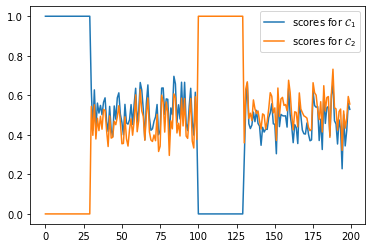

In [235]:
p  = 20
n  = 200
nl = 60
nu = n-nl
alpha = -1

cs = [1/2, 1/2]
k = len(cs) # nb of classes

np.random.seed(928)

means = lambda i : np.concatenate([[2*(-1)**i],np.zeros(p-1)])
covs  = lambda i : np.eye(p)

label_ind   = [0]*nl
unlabel_ind = [0]*nu
X=np.zeros( (p,n) )
S=np.zeros( (n,k) )
for i in range(k):
    label_ind[int(np.sum(cs[:i])*nl):int(np.sum(cs[:i+1]*nl))] = range(int(np.sum(cs[:i]*n)),int(np.sum(cs[:i]*n)+cs[i]*nl))
    unlabel_ind[int(np.sum(cs[:i])*nu):int(np.sum(cs[:i+1]*nu))] = range(int(np.sum(cs[:i]*n)+cs[i]*nl),int(np.sum(cs[:i+1]*n)))
    X[:,int(np.sum(cs[:i])*n):int(np.sum(cs[:i+1]*n))]=scipy.linalg.sqrtm(covs(i+1))@np.random.randn(p,int(cs[i]*n))+means(i+1).reshape(p,1)
    S[int(np.sum(cs[:i])*n):int(np.sum(cs[:i+1]*n)),i] = 1
    
XX = X.T@X

K = np.exp(-(-2*(XX)+np.diag(XX).reshape(1,n)+np.diag(XX).reshape(n,1))/p/2)
d = np.sum(K,axis=0)

K_ul = K[unlabel_ind,:][:,label_ind]
K_uu = K[unlabel_ind,:][:,unlabel_ind]

Sl = S[label_ind,:]

dl = d[label_ind]
du = d[unlabel_ind]

hat_Su = np.linalg.solve( np.eye(nu) - np.diag(du**(-1-alpha))@K_uu@np.diag(du**alpha) , np.diag(du**(-1-alpha))@K_ul@np.diag(dl**alpha)@Sl )
S[unlabel_ind,:] = hat_Su

plt.plot(S[:,0],label=r'scores for $\mathcal{C}_1$')
plt.plot(S[:,1],label=r'scores for $\mathcal{C}_2$')
_ = plt.legend()

## First intuitions on MNIST data

In [238]:
cs = [1/2,1/2]
k = len(cs) # nb of classes

n = 200
alpha = -1
nl = 60
nu = n - nl
label_ind = [0]*nl
unlabel_ind = [0]*nu

(init_data, init_labels), _ = mnist.load_data()

idx_init_labels = np.argsort(np.array(init_labels))
    
labels = init_labels[idx_init_labels]
init_data = init_data[idx_init_labels,:,:]
data = np.transpose(init_data.reshape(np.shape(init_data)[0],np.shape(init_data)[1]*np.shape(init_data)[2]))
init_n,p=np.shape(data)[1],np.shape(data)[0]

selected_labels=[1,2] # selected digits: must be of size 'k'

## Data preprocessing

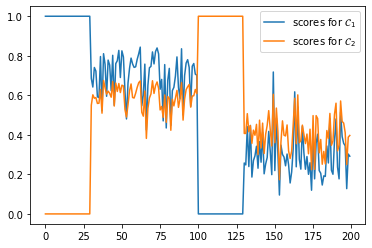

In [239]:
data = data/data.max()
mean_data=np.mean(data,axis=1).reshape(len(data),1)

norm2_data=0
for i in range(init_n):
    norm2_data+=1/init_n*np.linalg.norm(data[:,i]-mean_data)**2

data=np.mat((data-mean_data)/np.sqrt(norm2_data)*np.sqrt(p))

selected_data = []

for i in range(len(selected_labels)):
    selected_data.append(data[:,[ x for x in range(init_n) if labels[x]==selected_labels[i] ] ])
    if i==0:    
        cascade_selected_data = selected_data[-1]
    else:
        np.concatenate([cascade_selected_data,selected_data[-1]],axis=1)

# recentering of the k classes
mean_selected_data  = np.mean(cascade_selected_data,axis=1).reshape(len(cascade_selected_data),1)
norm2_selected_data = np.mean(np.sum(np.power(np.abs(cascade_selected_data-mean_selected_data),2),0))

for j in range(len(selected_labels)):
    selected_data[j]=(selected_data[j]-mean_selected_data)/np.sqrt(norm2_selected_data)*np.sqrt(p)

means = lambda l : np.mean(selected_data[l],axis=1)
covs  = lambda l : 1/np.shape(selected_data[l])[1]*(selected_data[l]@selected_data[l].T)-means(l)@means(l).T

X= np.zeros((p,n))
S= np.zeros((n,k))
for i in range(k):
    label_ind[int(np.sum(cs[:i])*nl):int(np.sum(cs[:i+1]*nl))] = range(int(np.sum(cs[:i]*n)),int(np.sum(cs[:i]*n)+cs[i]*nl))
    unlabel_ind[int(np.sum(cs[:i])*nu):int(np.sum(cs[:i+1]*nu))] = range(int(np.sum(cs[:i]*n)+cs[i]*nl),int(np.sum(cs[:i+1]*n)))
    data = selected_data[i][:,np.random.permutation(np.shape(selected_data[i])[1])]
    X[:,int(np.sum(cs[:i])*n):int(np.sum(cs[:i+1])*n)]=data[:,:int(n*cs[i])] 
    S[int(np.sum(cs[:i])*n):int(np.sum(cs[:i+1]*n)),i] = 1    
    
XX = X.T@X
K = np.exp(-(-2*(XX)+np.diag(XX).reshape(1,n)+np.diag(XX).reshape(n,1))/p/2)
d = np.sum(K,axis=0)

K_ll = K[label_ind,:][:,label_ind]
K_ul = K[unlabel_ind,:][:,label_ind]
K_lu = K[label_ind,:][:,unlabel_ind]
K_uu = K[unlabel_ind,:][:,unlabel_ind]

Sl = S[label_ind,:]

dl = d[label_ind]
du = d[unlabel_ind]

hat_Su = np.linalg.solve( np.eye(nu) - np.diag(du**(-1-alpha))@K_uu@np.diag(du**alpha) , np.diag(du**(-1-alpha))@K_ul@np.diag(dl**alpha)@Sl )
S[unlabel_ind,:] = hat_Su

plt.plot(S[:,0],label=r'scores for $\mathcal{C}_1$')
plt.plot(S[:,1],label=r'scores for $\mathcal{C}_2$')
_ = plt.legend()

## Empirical classification of "classical" Laplacian approach

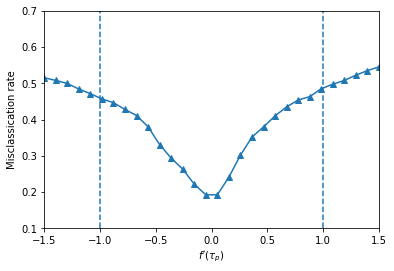

In [240]:
cs = [1/2,1/2]
k = len(cs) # nb of classes

n = 1024
p = 512
alpha = -1
nl = n//16
nu = n - nl
label_ind = [0]*nl
unlabel_ind = [0]*nu

kernel = 'poly2' # 'gauss' or 'poly2'

means = lambda i : np.zeros(p)
covs  = lambda i : (1 + i*3/np.sqrt(p))*np.eye(p)

np.random.seed(928)

X=np.zeros( (p,n) )
S=np.zeros( (n,k) )
for i in range(k):
    label_ind[int(np.sum(cs[:i])*nl):int(np.sum(cs[:i+1]*nl))] = range(int(np.sum(cs[:i]*n)),int(np.sum(cs[:i]*n)+cs[i]*nl))
    unlabel_ind[int(np.sum(cs[:i])*nu):int(np.sum(cs[:i+1]*nu))] = range(int(np.sum(cs[:i]*n)+cs[i]*nl),int(np.sum(cs[:i+1]*n)))
    X[:,int(np.sum(cs[:i])*n):int(np.sum(cs[:i+1]*n))]=scipy.linalg.sqrtm(covs(i))@np.random.randn(p,int(cs[i]*n))+means(i).reshape(p,1)
    S[int(np.sum(cs[:i])*n):int(np.sum(cs[:i+1]*n)),i] = 1
    
XX = X.T@X

tau = 2*np.trace(cs[0]*covs(0) + cs[1]*covs(1))/p

nb_param = 30
if kernel == 'gauss':
    sigma2_loop = [2**x for x in np.linspace(-5,5,nb_param)]
    param_loop  = sigma2_loop

if kernel == 'poly2':
    fp_tau_loop = np.linspace(-1.5,1.5,nb_param)
    param_loop  = fp_tau_loop

store_error = []

for param_index in range(nb_param):

    if kernel == 'gauss':
        sigma2 = sigma2_loop[param_index]
        f = lambda t : np.exp(-t/2/sigma2)
    
    if kernel == 'poly2':
        fp_tau = fp_tau_loop[param_index]
        derivs=[1,fp_tau,1]
        coeffs=np.zeros(len(derivs))
        
        for i in range(len(derivs)):
            coeffs[i]=derivs[-i-1]/np.math.factorial(len(derivs)-i)

        f = lambda t : np.polyval(coeffs,t-tau)

    K = f((-2*(XX)+np.diag(XX).reshape(1,n)+np.diag(XX).reshape(n,1))/p)
    d = np.sum(K,axis=0)

    K_ul = K[unlabel_ind,:][:,label_ind]
    K_uu = K[unlabel_ind,:][:,unlabel_ind]

    Sl = S[label_ind,:]

    dl = d[label_ind]
    du = d[unlabel_ind]

    hat_Su = np.linalg.solve( np.eye(nu) - np.diag(du**(-1-alpha))@K_uu@np.diag(du**alpha) , np.diag(du**(-1-alpha))@K_ul@np.diag(dl**alpha)@Sl )
    S[unlabel_ind,:] = hat_Su

    estim_vec_C1 = S[unlabel_ind,0]>S[unlabel_ind,1]
    estim_vec_C2 = 1 - estim_vec_C1
    vec_C1 = np.concatenate([np.ones(int(nu*cs[0])),np.zeros(int(nu*cs[1]))])
    vec_C2 = 1 - vec_C1

    store_error.append(1- np.sum(estim_vec_C1*vec_C1 + estim_vec_C2*vec_C2)/nu)

if kernel == 'gauss':
    plt.semilogx(sigma2_loop,store_error, '^-')
    plt.xlabel(r'$\sigma^2$')
    plt.ylabel('Misclassication rate')
    plt.gca().set_xlim([np.min(sigma2_loop),np.max(sigma2_loop)])
    plt.gca().set_ylim([0.25,0.75])

if kernel == 'poly2':
    plt.plot(fp_tau_loop,store_error, '^-')
    plt.xlabel(r'$f^{\prime}(\tau_p)$')
    plt.ylabel('Misclassication rate')
    plt.gca().set_xlim([np.min(fp_tau_loop),np.max(fp_tau_loop)])
    plt.gca().set_ylim([.1,.7])
    plt.axvline(-1,ls='--')
    plt.axvline( 1,ls='--')
    
_ = plt.show()  


## Improved semi-supervised learning: theoretical misclassification rate on function of $\theta$

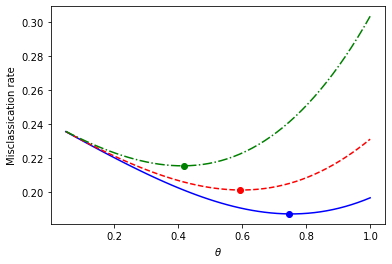

In [170]:
p = 100
covs = scipy.linalg.toeplitz([.1**i for i in range(p)])
Delta_mu = np.concatenate([[2],np.zeros(p-1)])

cs = [1/2,1/2]
thetas = np.linspace(.05,1-1e-3,50)

testcase = 'nu' # nu or nl

if testcase == 'nu':
    nus = [800, 400, 200]
    nl = 100
    params = nus
if testcase == 'nl':
    nu = 800
    nls = [400, 200, 100]
    params = nls

def qfunc(x):
    return 0.5-0.5*scipy.special.erf(x/np.sqrt(2))
    
store_output = np.zeros( (len(params),len(thetas)) )
for i in range(len(params)):
    if testcase == 'nu':
        nu = nus[i]
    if testcase == 'nl':
        nl = nls[i]

    for iter,theta in enumerate(thetas):
        xi = scipy.optimize.fsolve( lambda t : cs[0]*cs[1]*t*(Delta_mu@np.linalg.solve(np.eye(p) - t*covs,Delta_mu)) - theta, .5 )[0]

        inv_C_Delta_mu = np.linalg.solve(np.eye(p) - xi*covs,Delta_mu)
        eta = xi**2*np.linalg.norm( np.linalg.solve(np.eye(p) - xi*covs,covs),'fro')**2
        zeta = cs[0]*cs[1]*xi**2*inv_C_Delta_mu@covs@inv_C_Delta_mu

        E = 2*nl*theta/nu/(1-theta)
        V = cs[0]*cs[1]*( (2*nl+E*nu)**2*zeta + (4*nl + E**2*nu)*eta )/( nu*(nu-eta) )

        store_output[i,iter] = cs[0]*qfunc((1-cs[0])*E/np.sqrt(V)) + cs[1]*qfunc((1-cs[1])*E/np.sqrt(V))

ind1 = np.argmin(store_output[0,:])
max1 = store_output[0,ind1]
ind2 = np.argmin(store_output[1,:])
max2 = store_output[1,ind2]
ind3 = np.argmin(store_output[2,:])
max3 = store_output[2,ind3]

if testcase == 'nu':                                   
    plt.plot(thetas, store_output[0,:],'b',label=r'$n_{[u]} = 800$')
    plt.plot(thetas, store_output[1,:],'r--',label=r'$n_{[u]} = 400$')
    plt.plot(thetas, store_output[2,:],'g-.',label=r'$n_{[u]} = 200$')
                                   
if testcase == 'nl':                                   
    plt.plot(thetas, store_output[0,:],'b',label=r'$n_{[l]} = 400$')
    plt.plot(thetas, store_output[1,:],'r--',label=r'$n_{[l]} = 200$')
    plt.plot(thetas, store_output[2,:],'g-.',label=r'$n_{[l]} = 100$')
                                   
plt.plot(thetas[ind1], max1, 'bo')
plt.plot(thetas[ind2], max2, 'ro')
plt.plot(thetas[ind3], max3, 'go')

plt.xlabel(r'$\theta$')
plt.ylabel('Misclassication rate')
_ = plt.show()

## Improved semi-supervised learning: empirical misclassification rate on Gaussian data

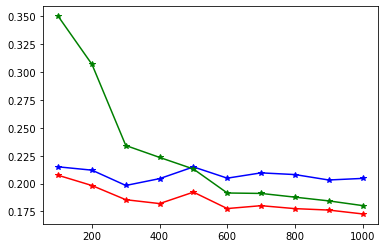

In [190]:
cs = [1/2,1/2]
k = len(cs) # nb of classes
p = 100
nl = 200

means = lambda a : (-1)**a*np.concatenate([[1],np.zeros(p-1)])
covs = lambda a : np.eye(p)
P = lambda n : np.eye(n) - np.ones( (n,n) )/n

nu_loop = range(100,1100,100)
store_error = np.zeros( (len(nu_loop),3) )

nb_average_loop = 50
np.random.seed(928)

for iter,nu in enumerate(nu_loop):
    n = nl + nu
    label_ind = [0]*nl
    unlabel_ind = [0]*nu

    vec_C1 = np.concatenate([np.ones(int(nu*cs[0])),np.zeros(int(nu*cs[1]))])
    vec_C2 = 1 - vec_C1
    vec_C = -vec_C1 + vec_C2

    store_error_tmp = np.zeros( (nb_average_loop,3) )

    for average_index in range(nb_average_loop):
        X=np.zeros( (p,n) )
        S=np.zeros( (n,k) )
        for i in range(k):
            label_ind[int(np.sum(cs[:i])*nl):int(np.sum(cs[:i+1]*nl))] = range(int(np.sum(cs[:i]*n)),int(np.sum(cs[:i]*n)+cs[i]*nl))
            unlabel_ind[int(np.sum(cs[:i])*nu):int(np.sum(cs[:i+1]*nu))] = range(int(np.sum(cs[:i]*n)+cs[i]*nl),int(np.sum(cs[:i+1]*n)))
            X[:,int(np.sum(cs[:i])*n):int(np.sum(cs[:i+1]*n))]=scipy.linalg.sqrtm(covs(i))@np.random.randn(p,int(cs[i]*n))+means(i).reshape(p,1)
            S[int(np.sum(cs[:i])*n):int(np.sum(cs[:i+1]*n)),i] = 1

        XX = X.T@X
        
        f = lambda t : np.exp(-t/2)
        K = f((-2*(XX)+np.diag(XX).reshape(1,n)+np.diag(XX).reshape(n,1))/p)
        d = np.sum(K,axis=0)     
        
        
        # RMT-improved
        hat_K = P(n)@K@P(n)

        hat_K_ll = hat_K[label_ind,:][:,label_ind]
        hat_K_lu = hat_K[label_ind,:][:,unlabel_ind]
        hat_K_ul = hat_K[unlabel_ind,:][:,label_ind]
        hat_K_uu = hat_K[unlabel_ind,:][:,unlabel_ind]

        hat_Sl = P(nl)@S[label_ind,:]

        alpha = np.linalg.norm(hat_K_uu,2)+1
        hat_Su = np.linalg.solve(alpha*np.eye(nu) - hat_K_uu, hat_K_ul)@hat_Sl
        S[unlabel_ind,:] = hat_Su

        estim_vec_C1 = (S[unlabel_ind,0]>S[unlabel_ind,1])
        estim_vec_C2 = 1 - estim_vec_C1
        store_error_tmp[average_index,0] = 1- np.sum(estim_vec_C1*vec_C1 + estim_vec_C2*vec_C2)/nu

        # classical Laplacian
        alpha = -1

        K_ll = K[label_ind,:][:,label_ind]
        K_lu = K[label_ind,:][:,unlabel_ind]
        K_ul = K[unlabel_ind,:][:,label_ind]
        K_uu = K[unlabel_ind,:][:,unlabel_ind]

        Sl = S[label_ind,:]

        dl = d[label_ind]
        du = d[unlabel_ind]

        hat_Su = np.linalg.solve(np.eye(nu) - np.diag(du**(-1-alpha))@K_uu@np.diag(du**alpha),np.diag(du**(-1-alpha))@K_ul@np.diag(dl**alpha)@Sl)
        S[unlabel_ind,:] = hat_Su

        estim_vec_C1 = (S[unlabel_ind,0]>S[unlabel_ind,1])
        estim_vec_C2 = 1 - estim_vec_C1

        store_error_tmp[average_index,1] = 1- np.sum(estim_vec_C1*vec_C1 + estim_vec_C2*vec_C2)/nu

        # kernel spectral clustering
        v = scipy.sparse.linalg.eigsh(P(nu)@K_uu@P(nu), 1)[1][:,0]
        if vec_C@v < 0:
            v = -v

        store_error_tmp[average_index,2] = 1-np.sum(np.sign(v)==vec_C)/nu

    store_error[iter,0] = np.mean(store_error_tmp[:,0])
    store_error[iter,1] = np.mean(store_error_tmp[:,1])
    store_error[iter,2] = np.mean(store_error_tmp[:,2])


plt.plot(nu_loop,store_error[:,0], 'r*-',label='RMT improved')
plt.plot(nu_loop,store_error[:,1],'b*-',label='Classical Laplacian')
plt.plot(nu_loop,store_error[:,2],'g*-',label='Spectral Clustering')
_ = plt.legend()

## Intra- and inter-class distance of MNIST data

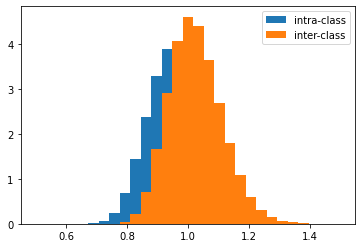

In [225]:
cs = [1/2,1/2]
k = len(cs) # nb of classes

n = 4000
selected_labels=[8,9]
noise_level_dB=3

(init_data, init_labels), _ = mnist.load_data()

idx_init_labels = np.argsort(np.array(init_labels))
    
labels = init_labels[idx_init_labels]
init_data = init_data[idx_init_labels,:,:]
data = np.transpose(init_data.reshape(np.shape(init_data)[0],np.shape(init_data)[1]*np.shape(init_data)[2]))
init_n,p=np.shape(data)[1],np.shape(data)[0]

# Data preprocessing
data = data/data.max()
mean_data=np.mean(data,axis=1).reshape(len(data),1)

norm2_data=0
for i in range(init_n):
    norm2_data+=1/init_n*np.linalg.norm(data[:,i]-mean_data)**2

data=np.mat((data-mean_data)/np.sqrt(norm2_data)*np.sqrt(p))

# Add Gaussian noise to data
noise_level=10**(noise_level_dB/10)
Noise = np.random.rand(p,init_n)*np.sqrt(12)*np.sqrt(noise_level*np.var(data[:]))
data+=Noise


# Select data
selected_data = []

for i in range(len(selected_labels)):
    selected_data.append(data[:,[ x for x in range(init_n) if labels[x]==selected_labels[i] ] ])
    if i==0:    
        cascade_selected_data = selected_data[-1]
    else:
        np.concatenate([cascade_selected_data,selected_data[-1]],axis=1)

# recentering of the k classes
mean_selected_data  = np.mean(cascade_selected_data,axis=1).reshape(len(cascade_selected_data),1)
norm2_selected_data = np.mean(np.sum(np.power(np.abs(cascade_selected_data-mean_selected_data),2)))

X= np.zeros((p,n))
for i in range(k):
    label_ind[int(np.sum(cs[:i])*nl):int(np.sum(cs[:i+1]*nl))] = range(int(np.sum(cs[:i]*n)),int(np.sum(cs[:i]*n)+cs[i]*nl))
    unlabel_ind[int(np.sum(cs[:i])*nu):int(np.sum(cs[:i+1]*nu))] = range(int(np.sum(cs[:i]*n)+cs[i]*nl),int(np.sum(cs[:i+1]*n)))
    data = selected_data[i]
    X[:,int(np.sum(cs[:i])*n):int(np.sum(cs[:i+1])*n)]=data[:,:int(n*cs[i])] 

XX = X.T@X    
Dist = (-2*(XX)+np.diag(XX).reshape(1,n)+np.diag(XX).reshape(n,1))/p
Dist_intra = np.concatenate([Dist[:int(n*cs[0]),:int(n*cs[0])],Dist[int(n*cs[0]):,int(n*cs[0]):]])
Dist_inter = np.concatenate([Dist[:int(n*cs[0]),int(n*cs[0]):],Dist[int(n*cs[0]):,:int(n*cs[0])]])

mean_Dist = np.mean(np.concatenate([Dist_inter.flatten(),Dist_intra.flatten()]))

edges = np.linspace(.5,1.5,30)
plt.hist(Dist_intra.flatten()/mean_Dist,bins=edges,weights=1/(edges[1]-edges[0])/len(Dist_intra.flatten())*np.ones(len(Dist_intra.flatten())),label='intra-class')
plt.hist(Dist_inter.flatten()/mean_Dist,bins=edges,weights=1/(edges[1]-edges[0])/len(Dist_inter.flatten())*np.ones(len(Dist_inter.flatten())),label='inter-class')
_ = plt.legend()